## Basic Setup

In [35]:
import os
import sys
import random
import numpy as np
import pandas as pd

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from evaluation.plots import plot_history

In [72]:
# HYPERPARAMETERS
COMMENT = "Lets go"

IMAGE_SIZE = (256, 256)
INPUT_SHAPE = IMAGE_SIZE + (3,)

THRESHOLD_PERCENTAGE = 95

BOTTLENECK_DIM = 512
BATCH_SIZE = 32
EPOCHS = 2
LOSS = 'mae'
OPTIMIZER = 'adam'
DROPOUT = 0.3

In [37]:
import os

def get_root_dir():
    # Get the current working directory
    current_dir = os.getcwd()

    # Traverse up the directory tree until you find the root directory of the repo
    while not os.path.exists(os.path.join(current_dir, '.git')):
        current_dir = os.path.dirname(current_dir)

    return current_dir

root_dir = get_root_dir()

In [39]:
model_name = 'autoencoder'
model_dir = os.path.join(root_dir, 'models', model_name)

cpkt_path = os.path.join(model_dir, 'logs', 'checkpoints', f'{COMMENT}_checkpoint.model.keras')
history_path = os.path.join(model_dir, 'logs', 'history', f'{COMMENT}_history.csv')
weights_path = os.path.join(model_dir, 'logs', 'weights', f'{COMMENT}_model.keras')
assert not os.path.exists(weights_path), f'Path already exists: {weights_path}. Please change the comment.'

In [40]:
# set the random seeds to make sure that the results are reproducible
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)
                                
set_seed(1234)

In [41]:
import tensorflow as tf
import platform

def setup_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            if platform.system() == 'Darwin':  # macOS
                tf.config.experimental.set_memory_growth(gpus[0], True)
                print("Configured TensorFlow to use Metal on macOS.")
            else:  # Assume CUDA for other platforms
                tf.config.experimental.set_memory_growth(gpus[0], True)
                print("Configured TensorFlow to use CUDA.")
        except RuntimeError as e:
            print(e)
    else:
        print("No GPU found, using CPU.")

setup_gpu()

No GPU found, using CPU.


In [75]:
def get_data(category: str, batch_size: int):
    data_dir = f'../../data/{category}'
    train_dir = f'{data_dir}/train'
    test_dir = f'{data_dir}/test'

    datagen_train = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2
        )

    datagen_test = ImageDataGenerator(
        rescale=1./255
        )

    train_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='input',
        color_mode='rgb',
        subset='training'
    )

    validation_generator = datagen_train.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='input',
        color_mode='rgb',
        subset='validation'
    )

    test_generator = datagen_test.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = get_data(category='screw', batch_size=BATCH_SIZE)

Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 160 images belonging to 6 classes.


In [43]:
def build_autoencoder(input_shape, optimizer, loss, dropout, bottleneck_dim):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (128, 128, 32)
    x = Dropout(dropout)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (64, 64, 64)+
    x = Dropout(dropout)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # (32, 32, 128)
    x = Dropout(dropout)(x)

    # Bottleneck
    x = Flatten()(x)                        # Flattened Shape: (32 * 32 * 128,)
    encoded = Dense(bottleneck_dim)(x)      # Latent space size reduced to 512
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU(name='bottleneck')(encoded)

    # Decoder
    x = Dense(32 * 32 * 128)(encoded)
    x = Reshape((32, 32, 128))(x)

    x = UpSampling2D((2, 2))(x)  # (64, 64, 128)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (128, 128, 64)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = UpSampling2D((2, 2))(x)  # (256, 256, 32)
    x = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, x)
    autoencoder.compile(
        optimizer=optimizer, 
        loss=loss,
        metrics=['accuracy']
        )
    
    return autoencoder

autoencoder = build_autoencoder(input_shape=INPUT_SHAPE, optimizer=OPTIMIZER, loss=LOSS, dropout=DROPOUT, bottleneck_dim=BOTTLENECK_DIM)

In [45]:
early_stop = EarlyStopping(
    monitor="val_accuracy", 
    mode="max", 
    patience=10, 
    start_from_epoch=10
    )

checkpoint = ModelCheckpoint(
    cpkt_path, 
    monitor="val_accuracy", 
    mode="max", 
    save_best_only=True, 
    verbose=1
    )

In [46]:
history = autoencoder.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
)

/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.3107 - loss: 0.2156 
Epoch 1: val_accuracy improved from -inf to 0.14732, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/Lets go_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 16s/step - accuracy: 0.3063 - loss: 0.2091 - val_accuracy: 0.1473 - val_loss: 0.1717
Epoch 2/2
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.3745 - loss: 0.0621 
Epoch 2: val_accuracy improved from 0.14732 to 0.24362, saving model to /Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/models/autoencoder/logs/checkpoints/Lets go_checkpoint.model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 152s 20s/step - accuracy: 0.3777 - loss: 0.0616 - val_accuracy: 0.2436 - val_loss: 0.2004


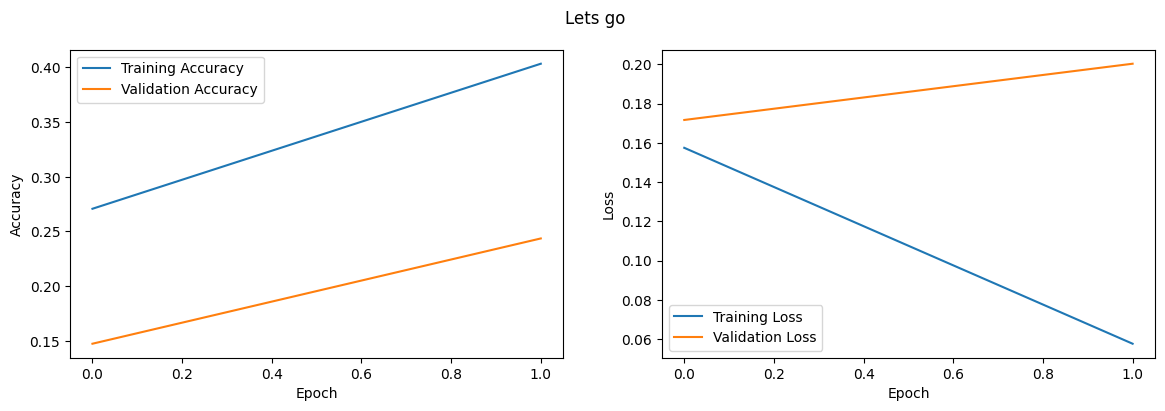

Best train_accuracy: 0.4034
Best train_loss: 0.0576
Best val_accuracy: 0.2436
Best val_loss: 0.1717
Last improvement at epoch: 2


In [47]:
# plot the training history
plot_history(comment=COMMENT, history=history)

In [48]:
# save the history
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.to_csv(history_path, index=False)

In [49]:
# load the best model
autoencoder.load_weights(cpkt_path)

In [50]:
# save the model
autoencoder.save(weights_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


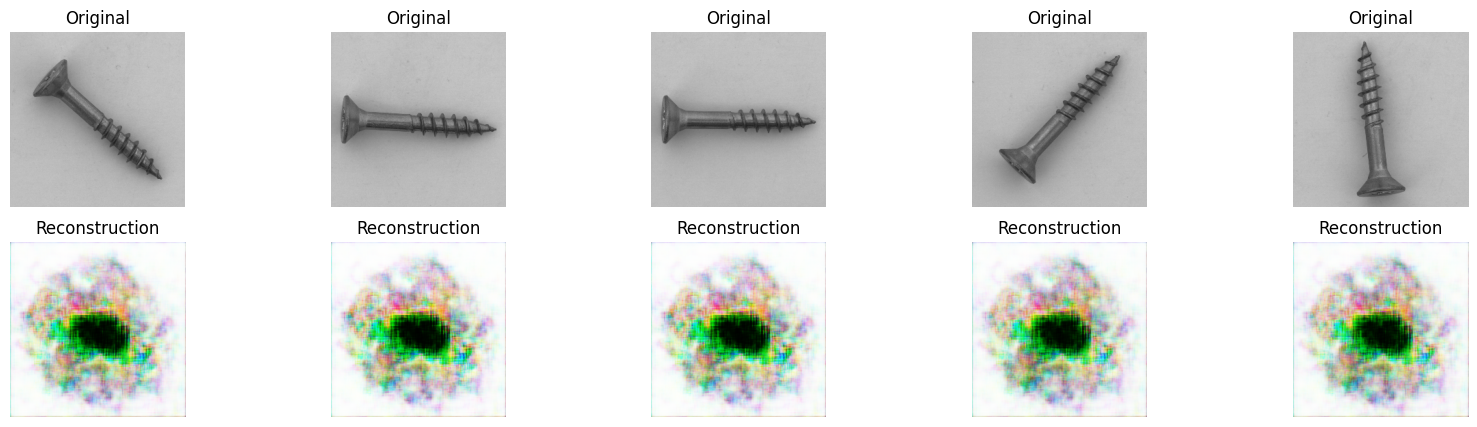

In [76]:
def plot_reconstructions(autoencoder, test_generator, n_images):
    test_images, _ = next(test_generator)
    reconstructions = autoencoder.predict(test_images)

    fig, axes = plt.subplots(2, n_images, figsize=(20, 5))

    for i in range(n_images):
        axes[0, i].imshow(test_images[i])
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruction')

    plt.show()

plot_reconstructions(autoencoder, test_generator, n_images=5)

In [63]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Threshold: 0.21074913442134857


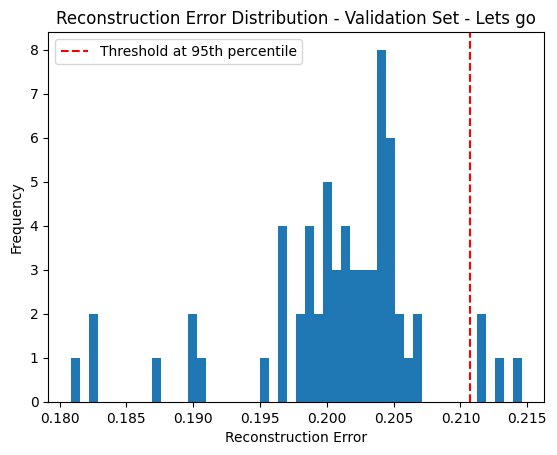

In [73]:
def calculate_reconstruction_error(autoencoder, validation_generator):
    val_errors = []
    for i in range(len(validation_generator)):
        val_images, _ = next(validation_generator)
        reconstructions = autoencoder.predict(val_images)
        val_errors.extend(np.mean(np.abs(reconstructions - val_images), axis=(1, 2, 3)))
    return val_errors

validation_errors = calculate_reconstruction_error(autoencoder, validation_generator)

threshold = np.percentile(validation_errors, THRESHOLD_PERCENTAGE)
print(f"Threshold: {threshold}")

def plot_construction_errors(errors, threshold):
    plt.hist(errors, bins=50)
    plt.axvline(threshold, color='r', linestyle='dashed', label=f'Threshold at {THRESHOLD_PERCENTAGE}th percentile')
    plt.legend()
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title(f'Reconstruction Error Distribution - Validation Set - {COMMENT}')

plot_construction_errors(validation_errors, threshold)

Class Indices: {'good': 0, 'manipulated_front': 1, 'scratch_head': 2, 'scratch_neck': 3, 'thread_side': 4, 'thread_top': 5}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


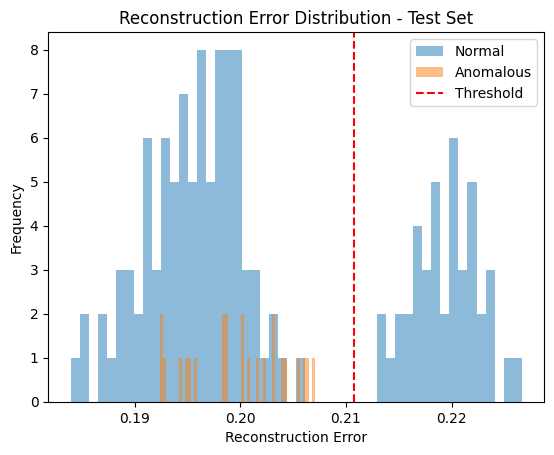

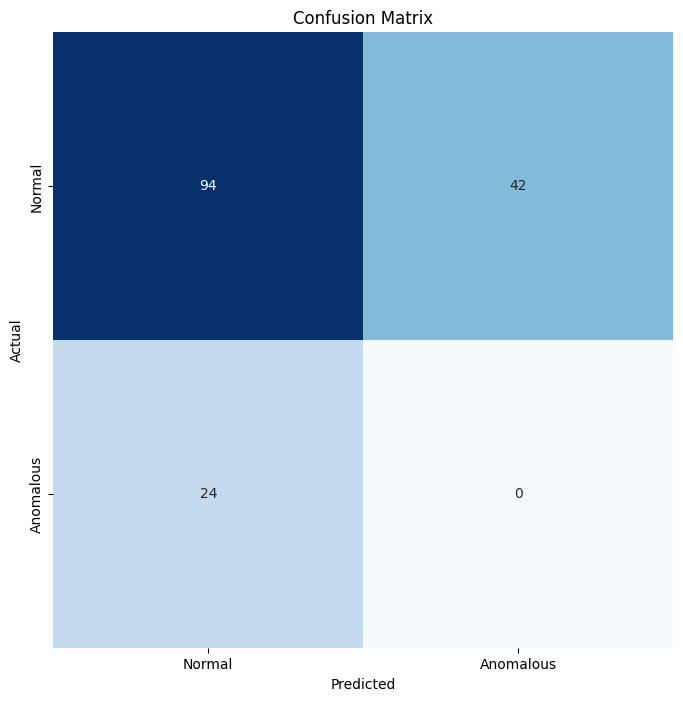

In [ ]:
print("Class Indices:", test_generator.class_indices)
good_class_index = test_generator.class_indices['good']

def calculate_test_errors_and_labels(autoencoder, test_generator):
    test_errors = []
    true_labels = []
    for i in range(len(test_generator)):
        test_images, test_labels = next(test_generator)
        reconstructions = autoencoder.predict(test_images)
        errors = np.mean(np.abs(reconstructions - test_images), axis=(1, 2, 3))
        test_errors.extend(errors)
        true_labels.extend(test_labels[:, 1])
    return np.array(test_errors), np.array(true_labels)

test_errors, true_labels = calculate_test_errors_and_labels(autoencoder, test_generator)

true_labels = np.where(true_labels == good_class_index, 0, 1)
predicted_labels = np.where(test_errors > threshold, 1, 0)

classification_report = classification_report(true_labels, predicted_labels, target_names=['normal', 'anomaly'])
confusion_matrix = confusion_matrix(true_labels, predicted_labels)

normal_errors = test_errors[true_labels == 0]
anomalous_errors = test_errors[true_labels == 1]

plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
plt.hist(anomalous_errors, bins=50, alpha=0.5, label='Anomalous')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title(f'Reconstruction Error Distribution - Test Set - {COMMENT}')
plt.show()

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {COMMENT}')
plt.show()

Total number of images in test set: 160
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 705ms/step


/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Class Indices: {'good': 0, 'anomaly': 1}


/var/folders/4v/mg6gp3rx0yj803ddxqcd01bc0000gn/T/ipykernel_36836/3616904607.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


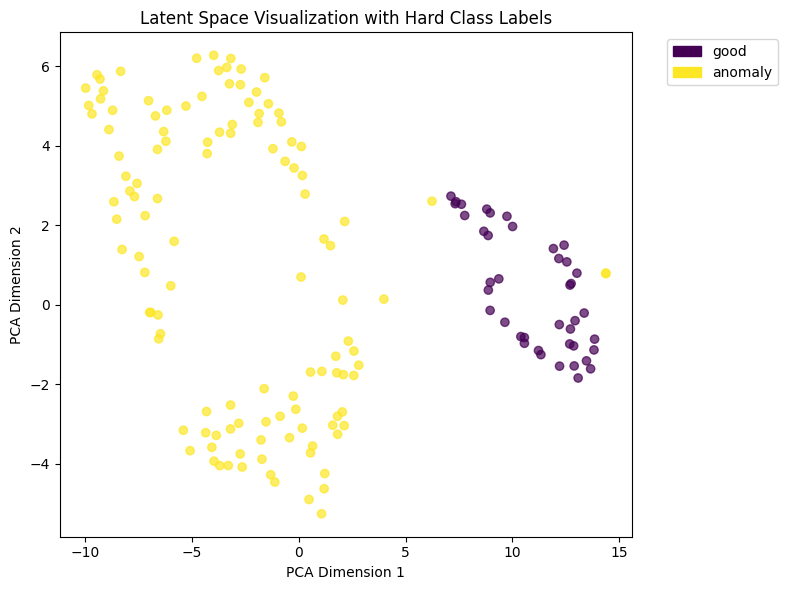

In [83]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Print the total number of images in the test dataset
print(f"Total number of images in test set: {test_generator.samples}")

# Get Bottleneck layer from the Encoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)

# Collect all images and labels from the test generator
all_images = []
all_labels = []

# Calculate the number of batches in the test generator
num_batches = int(np.ceil(test_generator.samples / test_generator.batch_size))

for i in range(num_batches):
    images_batch, labels_batch = next(test_generator)
    all_images.append(images_batch)
    all_labels.append(labels_batch)

# Concatenate all batches to get the full dataset
original_images = np.concatenate(all_images)
labels = np.concatenate(all_labels)

# Convert one-hot encoded labels to class indices
#labels_indices = np.argmax(labels, axis=1)
labels_indices = np.where((labels == [1, 0, 0, 0, 0, 0]).all(axis=1), 0, 1) 

# Get latent representations for all images
latent_representations = encoder.predict(original_images)

# Flatten the spatial dimensions of the latent representations
num_samples = latent_representations.shape[0]
latent_dimensionality = np.prod(latent_representations.shape[1:])
latent_flat = latent_representations.reshape(num_samples, latent_dimensionality)

# Apply t-SNE to reduce to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
latent_2d = tsne.fit_transform(latent_flat)

# Get class indices mapping
#class_indices = test_generator.class_indices
class_indices = {'good': 0, 'anomaly': 1}
print("Class Indices:", class_indices)
index_to_class = {v: k for k, v in class_indices.items()}

# Number of unique classes
num_classes = len(class_indices)

# Use a discrete colormap suitable for the number of classes

cmap = plt.cm.get_cmap('viridis', num_classes)

# Create a list of patches for the legend
patches = [mpatches.Patch(color=cmap(i), label=index_to_class[i]) for i in range(num_classes)]

# Plot the latent space with hard class labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                      c=labels_indices, cmap=cmap, alpha=0.7)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Latent Space Visualization with Hard Class Labels')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.tight_layout()
plt.show()